In [ ]:
!nvidia-smi

In [1]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import BertConfig, BertModel, BertForMaskedLM
from transformers import LineByLineTextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import torch
import matplotlib.pyplot as plt
import pandas as pd


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
maskedlm_model = BertForMaskedLM.from_pretrained("bert-large-uncased")

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased", do_lower_case=True)

In [4]:
print(tokenizer.tokenize('COVID'))
print(tokenizer.tokenize('coronavirus'))

['co', '##vid']
['corona', '##virus']


In [5]:
print (len(tokenizer)) 
tokenizer.add_tokens(["covid"]) 
tokenizer.add_tokens(["coronavirus"])
print (len(tokenizer)) 

30522
30524


In [16]:
print(tokenizer.tokenize('COVID'))
print(tokenizer.tokenize('covid'))
print(tokenizer.tokenize('coronavirus'))



['covid']
['covid']
['respiratory']


In [8]:
test_sentence = "COVID and coronavirus are bad"
print(tokenizer.tokenize(test_sentence))

['covid', 'and', 'coronavirus', 'are', 'bad']


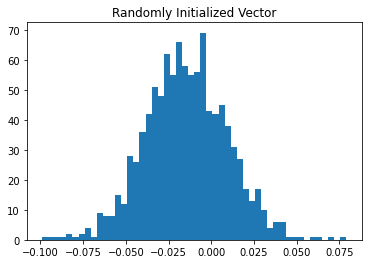

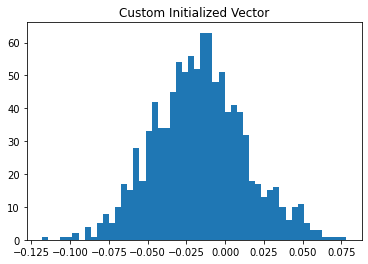

In [17]:
# FOR CORONAVIRUS:
maskedlm_model.resize_token_embeddings(len(tokenizer)) 
random_vector = maskedlm_model.get_input_embeddings().weight[-1].detach().numpy() # last one is covid random vector

plt.title("Randomly Initialized Vector")
plt.hist(random_vector, bins=50)
plt.show()

virus_id = tokenizer.convert_tokens_to_ids("virus")
respiratory_id = tokenizer.convert_tokens_to_ids("respiratory")
virus_embedding = maskedlm_model.get_input_embeddings().weight[virus_id]
respiratory_embedding = maskedlm_model.get_input_embeddings().weight[respiratory_id]
mean_embedding = torch.mean(torch.stack([virus_embedding, respiratory_embedding]), dim=0)
maskedlm_model.get_input_embeddings().weight[-1].data[:] = mean_embedding
mean_vector = maskedlm_model.get_input_embeddings().weight[-1].detach().numpy()

plt.title("Custom Initialized Vector")
plt.hist(mean_vector, bins=50)
plt.show()

# For COVID:
maskedlm_model.get_input_embeddings().weight[-2].data[:] = mean_embedding


In [ ]:
dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="abstracts.txt",
    block_size=32,
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

training_args = TrainingArguments(   
    output_dir="./",
    overwrite_output_dir=True,
    learning_rate=5e-06, 
    num_train_epochs=1,
    per_gpu_train_batch_size=16,
    save_steps=1000,
    #save_total_limit=2,
)

# Set up trainer
trainer = Trainer(
    model=maskedlm_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset= dataset
)

In [ ]:
trainer.train()

In [ ]:
trainer.save_model("covid_trained_bert")

In [ ]:
tokenizer.save_pretrained("covid_trained_bert_tok")